In [141]:
import sys
import json
params = {}
default = {'training_folder': '../../scenarios/dallas/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/dallas/', 'params': {}}


In [142]:
def get_filepath(path,filename):
    '''
    get filePath cas insensitive (ex: read demand.csv but file is name DEMAND.csv)
    path:'path/ ex: '../../scenarios/base/inputs/'
    filename: ex: demand.csv
    '''
    files = os.listdir(path)
    file = [file for file in files if filename.lower() == file.lower()]
    if len(file)==0:
        print(f'{path+filename} does not exist')
        return path+filename
    return path+file[0]

In [143]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)
from syspy.spatial import spatial, polygons

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [144]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(base_folder, 'model/')


In [145]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario='base', return_ancestry=False)
if 'params' in argv.keys():
    var.update(pd.DataFrame.from_dict(argv['params'], orient="index").stack())

# inputs

In [146]:
links = gpd.read_file(pt_folder + 'links.geojson', engine=io_engine) 
nodes = gpd.read_file(pt_folder + 'nodes.geojson', engine=io_engine)
links = links.set_index('index')
nodes = nodes.set_index('index')

In [147]:
rnodes = gpd.read_file(road_folder + 'road_nodes.geojson', engine=io_engine)
rnodes = rnodes.set_index('index')
rlinks = gpd.read_file(road_folder + 'road_links.geojson', engine=io_engine)
rlinks = rlinks.set_index('index')

In [148]:
filepath = get_filepath(input_folder,'zones.geojson')
zones = gpd.read_file(filepath)
zones = zones.set_index('index')

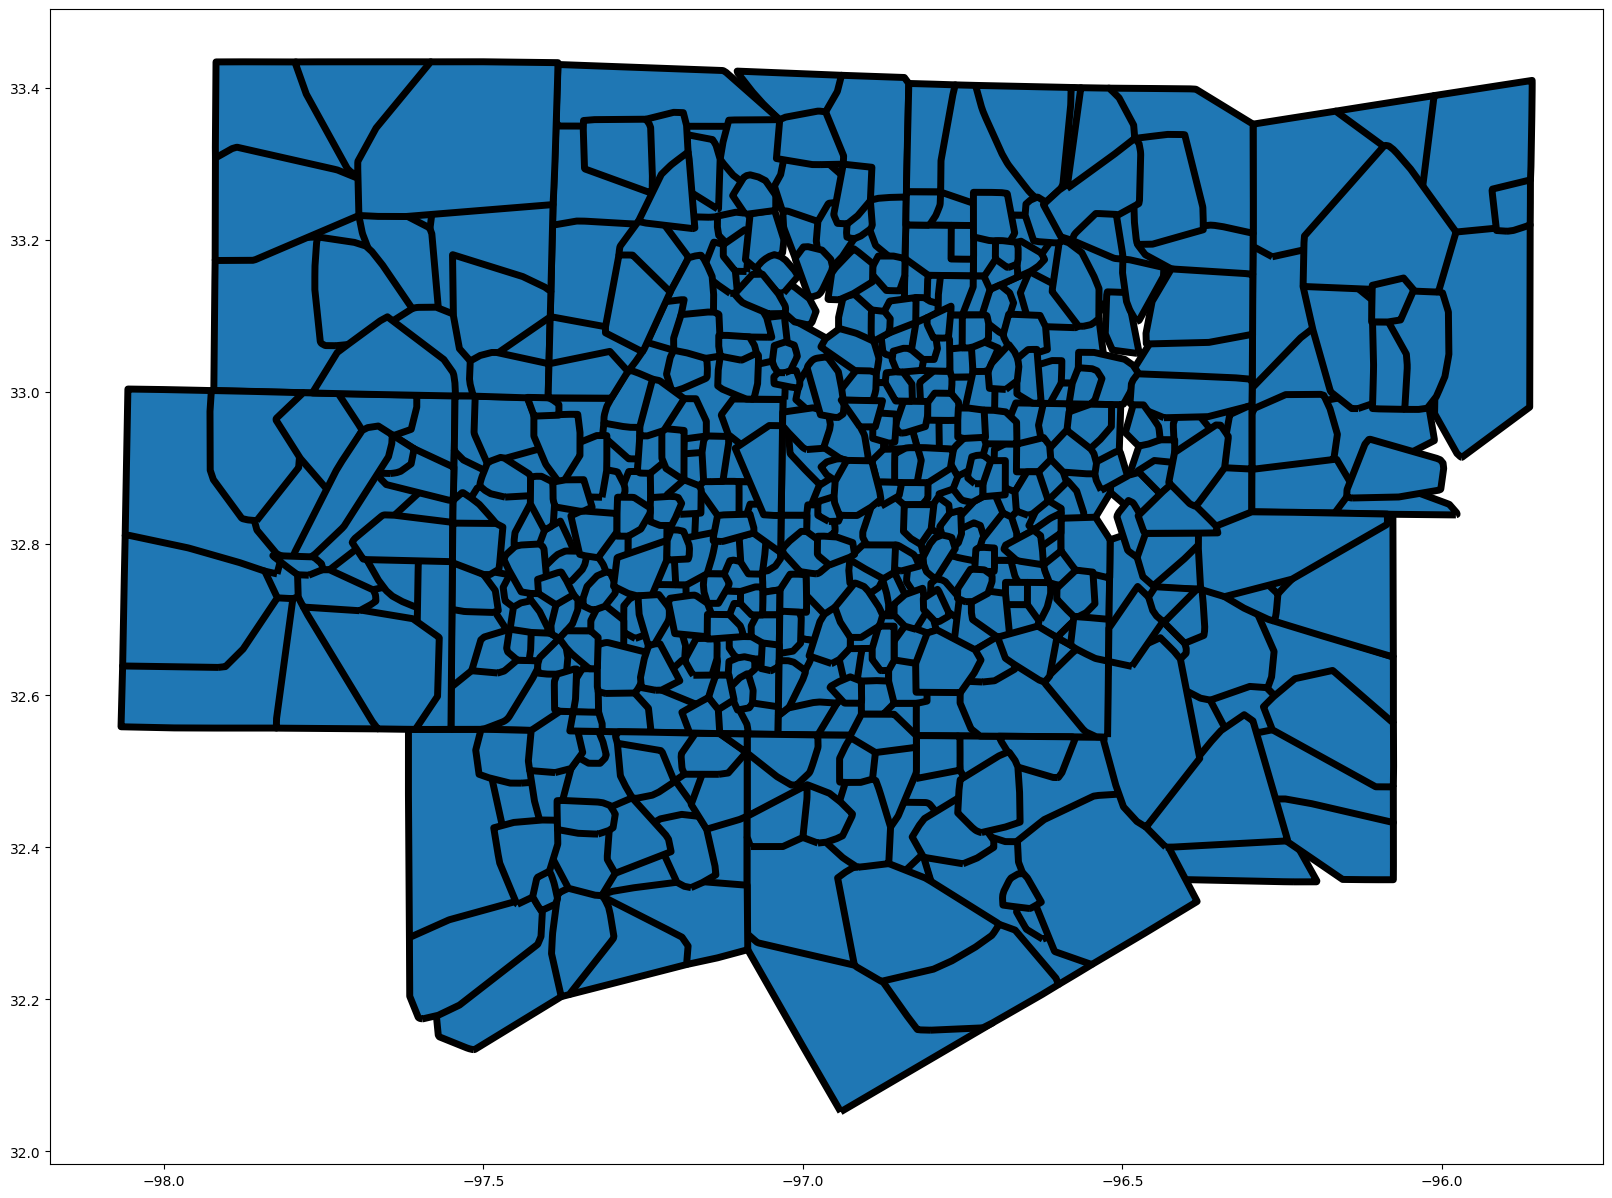

In [149]:
clusters = var['network_preparation']['n_clusters'] 

a, b = spatial.zone_clusters(zones, n_clusters=clusters)
plot = gpd.GeoDataFrame(a).plot(figsize=[25, 15], edgecolor='black', linewidth=5)


In [150]:
a , b

(                                                  geometry
 cluster                                                   
 0        POLYGON ((-96.81336 32.98705, -96.81894 32.987...
 1        POLYGON ((-97.30321 32.74856, -97.32041 32.781...
 2        POLYGON ((-96.61341 32.62717, -96.61906 32.643...
 3        POLYGON ((-96.53843 32.90778, -96.54300 32.907...
 4        POLYGON ((-96.97549 32.67120, -96.97818 32.671...
 ...                                                    ...
 495      POLYGON ((-96.92146 32.67644, -96.92244 32.676...
 496      POLYGON ((-97.31399 32.55263, -97.31991 32.552...
 497      POLYGON ((-97.05363 33.10240, -97.05885 33.104...
 498      POLYGON ((-97.03830 32.57336, -97.03731 32.633...
 499      POLYGON ((-97.26508 32.46476, -97.26620 32.464...
 
 [500 rows x 1 columns],
 index
 1       333
 2       130
 3       354
 4       251
 5        43
        ... 
 1700    396
 1701    359
 1702    211
 1703     46
 1704    312
 Name: cluster, Length: 1704, dtype: int32)

In [151]:
zones['cluster']= b
zones_agg = zones.groupby(['cluster'])['density', 'population', 'jobs'].sum()
zones_agg =gpd.GeoDataFrame(zones_agg, geometry= a['geometry'])
zones_agg

,density,population,jobs,geometry
cluster,,,,
0,21395.9,22211,18061,"POLYGON ((-96.81336 32.98705, -96.81894 32.987..."
1,9696.2,28280,9255,"POLYGON ((-97.30321 32.74856, -97.32041 32.781..."
2,442.4,4958,558,"POLYGON ((-96.61341 32.62717, -96.61906 32.643..."
3,6011.6,16558,1878,"POLYGON ((-96.53843 32.90778, -96.54300 32.907..."
4,9747.0,23392,5485,"POLYGON ((-96.97549 32.67120, -96.97818 32.671..."
...,...,...,...,...
495,9236.6,22424,6963,"POLYGON ((-96.92146 32.67644, -96.92244 32.676..."
496,3743.0,15033,4089,"POLYGON ((-97.31399 32.55263, -97.31991 32.552..."
497,3003.7,13174,1918,"POLYGON ((-97.05363 33.10240, -97.05885 33.104..."


# split quenedi road links


In [152]:
from quetzal.engine.road_model import RoadModel, _reverse_geom

self = RoadModel(rlinks,rnodes,zones,ff_time_col='time')
self.split_quenedi_rlinks()
rlinks = self.road_links
to_delete = [col for col in self.road_links.columns if col.endswith('_r')]
rlinks.drop(columns=to_delete,inplace=True)
del self

# create Model

In [153]:
sm = stepmodel.StepModel(epsg=4326)
sm.links = links
sm.nodes = nodes
sm.road_links = rlinks
sm.road_nodes = rnodes
sm.zones = zones_agg
sm.zone_before_clustering = zones

In [154]:
centroid = [*LineString(sm.nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])
crs

32614

In [155]:
sm = sm.change_epsg(crs,'meter')

Reprojecting model from epsg 4326 to epsg 32614: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


# clustering and walkmodel

In [156]:
sm.preparation_clusterize_nodes(distance_threshold=200)


In [157]:
#sm._add_type_prefixes({'nodes': 'node_','links':'link_','road_nodes':'road_node','road_links':'road_link_','zones':'zone_'})
sm._add_type_prefixes({'zones':'zone_'})

In [158]:
sm.road_links['walk_time'] = sm.road_links['length'] / var['footpaths']['wor_speed'] * 3.6

In [159]:
sm.preparation_footpaths(max_length=var['footpaths']['max_length'],
                         speed=var['footpaths']['speed'])


In [160]:
# Zone to transit
sm.preparation_ntlegs(
    short_leg_speed = var['zone_to_transit']['speed'],
    long_leg_speed = var['zone_to_transit']['speed'], # tout le monde marche
    threshold = var['zone_to_transit']['threshold'],
    zone_to_transit = True,
    zone_to_road = True,
    road_to_transit = True,
    n_ntlegs = var['zone_to_transit']['nbr'],
    max_ntleg_length = var['zone_to_transit']['max_length'],
)
sm._add_type_prefixes({'zone_to_transit':'ztt_'})

In [161]:
sm.integrity_test_all(errors='ignore', verbose=True)

failed: integrity_test_circular_lines
passed: integrity_test_collision


60008it [00:01, 57325.20it/s]


passed: integrity_test_dead_ends
passed: integrity_test_duplicate_volumes
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency
failed: integrity_test_road_duplicated_ab_links


60008it [00:04, 14273.35it/s]


failed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences
passed: integrity_test_str_collision


In [162]:
sm.road_links.drop_duplicates(subset= ['a','b'], inplace=True)

In [163]:
sm.zones.to_file(input_folder + 'zones_agg.geojson', driver= 'GeoJSON')

In [164]:
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

sm.to_zippedpickles(model_folder +'network')  

broken_sequences: 100%|██████████| 26/26 [00:04<00:00,  6.12it/s]   


<Axes: >

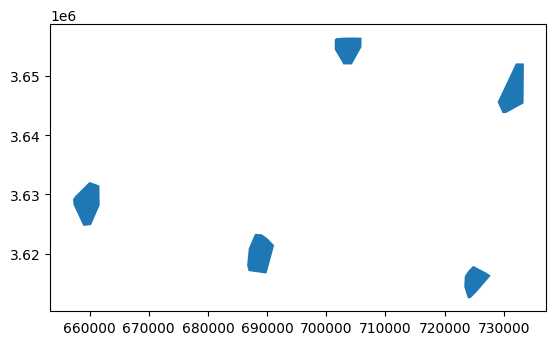

In [165]:
sm.zones['geometry'].iloc[1]
sm.zones.head().plot()

In [166]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined